In [42]:
#Define helper functions
function ptovPos(pos,Nmid,dcell)  # converts from physical to virtual units in position
    return (pos/dcell + float(Nmid)) # fractional position in vertual units
end

function vtopPos(pos,Nmid,dcell) # converts from virtual to physical units in position (natually placing the point at the center of a cell)
    return float((pos-Nmid))*dcell # returns the center of the cell in physical units
end

function ptovVel(vel,dv) # converts velocity to virtual units from physical units
    return vel/dv # units of cells/time step
end

function vtopVel(vel,dv) # converts velocity to physical units from virtual units
    return vel*dv # units of m/s
end

function solveFields(vf,ErDC,EzDC,ErAC,EzAC,Nrmid,Nzmid,Ni,dr,dz) # takes in particle positions in virtual units and spits out electric fields at all cells
    # vf is the vector of ion parameters
    # ErDC is the array of electric fields from the DC electrodes in r
    # EzDC is the array of electric fields from the DC electrodes in z
    # ErAC is the array of electric fields from the AC electrodes in r
    # EzAC is the array of electric fields from the AC electrodes in z
    # can improve this to replace the grid with E-fields by cell with a vector of E-fields by ion
    
    eps0 = 8.854e-12 #SI units 
    Erf2 = np.zeros(Ni)
    Ezf2 = np.zeros(Ni)
    for i=1:length(vf[:,1]) # note that this no longer takes the electric field from all particles, so chillax 
        jCell = convert(UInt32,round(vf[i,1])) # local cell index in r
        kCell = convert(UInt32,round(vf[i,2])) # local cell index in z
        Erf2[i] += ErDC[jCell,kCell] + ErAC[jCell,kCell]
        Ezf2[i] += EzDC[jCell,kCell] + EzAC[jCell,kCell]
        
        for j=1:length(vf[:,1])
            if j!=i #here we solve for the E-fields in this cell from the particles outside this cell
                rdist = (vf[j,1]-vf[i,1])*dr
                zdist = (vf[j,2]-vf[i,2])*dz
                sqDist = (rdist)^2 + (zdist)^2 #distance from particle to cell
                projR = rdist/sqDist^(1/2) #sin theta to project E field to r basis
                projZ = zdist/sqDist^(1/2) #cos theta to project E field to z basis
                
                Erf2[i] += -projR*vf[j,5]/(4*pi*eps0*sqDist) # add fields in r
                Ezf2[i] += -projZ*vf[j,5]/(4*pi*eps0*sqDist) # add fields in z 
            end
        end        
    end
    return Erf2,Ezf2
end

function ACFields(ErAC0,EzAC0,phaseAC,f,tstep,dt) # returns AC fields at each grid cell based on the amplitude at each cell, starting phase, and frequency
    return ErAC0.*sin.(phaseAC+tstep*dt),EzAC0.*sin.(phaseAC+tstep*dt)
end

function updateVels(vf,Erf,Ezf,dt,Nrmid,Nzmid,dr,dz,dvr,dvz) # apply the forces from the local electric field over one time step
    for i=1:length(vf[:,1]) 
        # apply E-field of the cell
        
        Fr = vf[i,5]*Erf[i]  # solve force 
        Fz = vf[i,5]*Ezf[i] 
        
        #then we would need to convert back to virtual units 
        vf[i,3] += ptovVel(Fr*dt/(vf[i,6]),dvr) # update velocity with F*t/m
        vf[i,4] += ptovVel(Fz*dt/(vf[i,6]),dvz)

    end
    return vf
end

function updatePoss(vf,dt,Nr,Nz) # move the particles one time step
    for i=1:length(vf[:,1]) 
        vf[i,1] += vf[i,3] # correct if virtual since one time step is passing
        vf[i,2] += vf[i,4]
        if vf[i,1]>Nr-1 || vf[i,1]<2
            println("Position out of simulation in r ",vf[i,1]," Particle # ",i," vf = ",vf[i,:])
            vf[i,:] = vf[i,:].*0.0
            vf[i,1] = 2.0
            vf[i,2] = 2.0
            vf[i,3] = 0.0
            vf[i,4] = 0.0
            vf[i,6] = 1e6
            
        elseif vf[i,2]>Nz-1 || vf[i,2]<2
            println("Position out of simulation in z ",vf[i,2]," Particle # ",i," vf = ",vf[i,:])
            vf[i,:] = vf[i,:].*0.0
            vf[i,1] = 2.0
            vf[i,2] = 2.0
            vf[i,3] = 0.0
            vf[i,4] = 0.0
            vf[i,6] = 1e6
        end
    end
    return vf
end

function makeRF0(m,q,w,Nr,Nz,Nrmid,dr) # dummy function to generate the RF field in our grid assuming that it is a harmonic potential about (0,0) and focuses in x
    # We take in the mass, frequency for that mass, cell numbers, midpoint, and physical width of a cell and output the RF electric fields (constant in z) as a function of radial cell
    C = -m*(w^2)/q
    RF = np.ones((Nr,Nz))
    for jCell=1:Nr
        RF[jCell,:] = -RF[jCell,:].*C*(Nrmid-jCell)*dr
    end
    return RF
end

function makeDC(m,q,w,Nz,Nr,Nzmid,dz) # dummy function to generate the DC fields assuming that it is a harmonic potential about (0,0) and focuses in z
    # We take in the mass, frequency for that mass, cell numbers, midpoint, and physical width of a cell and output the DC electric fields (constant in r) as a function of longitudinal cell
    C = -m*(w^2)/q
    DC = np.ones((Nr,Nz))
    for kCell=1:Nz
        DC[:,kCell] = -DC[:,kCell].*C*(Nzmid-kCell)*dz
    end
    return DC
end

function makeVField(m,q,wr,wz,Nr,Nz,Nrmid,Nzmid,dr,dz)
    # we assign voltage at each point given our trapping frequencies
    Cr = -0.5*m*(wr^2)/q
    Cz = -0.5*m*(wz^2)/q
    Vf = np.ones((Nr,Nz))
    for jCell=1:Nr
        for kCell=1:Nz
            Vf[jCell,kCell] = Cr*((Nrmid-jCell)*dr)^2 + Cz*((Nzmid-kCell)*dz)^2
        end
    end
    return Vf
end

function laserCoolSmooth(vf,vl,I0,nul,dnul,nu0,A,T,Ni,dt,dvr,dvz) # this takes the particle population and applies a global laser cooling field coupled to the radial and axial velocities that purely reduces the velocity like a true damping force
    # vf is particle pop
    # vl is the laser propagation vector (vr,vz) normalized to 1
    # I0 is laser peak intensity
    # nul is the laser frequency (all frequencies are angular frequencies)
    # dnul is the laser width
    # nu0 is the transition frequency
    # we assume the laser comes in counter to the positive velocity direction
    # A is the einstein A coefficient which gives spontaneous transition rate
    # T is the natural decay lifetime
    
    hbar = 1.05e-34 #plancks constant in J*s
    c = 2.998e8 #speed of light in m/s
    dnul2 = 2*dnul^2 #removed from for loop to save calc time
    C0=dt*(pi*c^2/(2*nu0^2))/(hbar*nu0) # this is the stimulated emission cross-section with only natural broadening divided by the photon energy assuming all transitions are the desired ultra-fast one
    # I'm treating the transition frequency as I*B/c which is equivalent to I*sigma / photon energy
    pl = hbar*nu0/c # for the momentum of the laser
    norm = 2^-(1/2) # 1/root2 for the unit vector multiple
    
    for i=1:Ni
        if vf[i,6]<1.0 #if the particle exists it should have a realistic mass
            vil = vf[i,3]*vl[1]+vf[i,4]*vl[2] #velocity of ion in laser propagation direction
            dopp = ((1+vil/c)/(1-vil/c))^(1/2) # the doppler shift assuming ion velocity is well below the speed of light
            nuInt = nu0/dopp # the doppler shifted ion transition frequency (really doppler shifts the laser) 
            abs0 = C0*I0*exp(-(nul-nuInt)^2/(dnul2))
            C1 = abs0*pl/vf[i,6] # fractional emitted photon velocity change
            dE = hbar*(nu0-nuInt)
            if dE>0
                #println("Cool ",dE)
                vf[i,3] -= vl[1]*abs0*(2*dE/vf[i,6])^(1/2)/dvr # radial velocity reduction from absorption
                vf[i,4] -= vl[2]*abs0*(2*dE/vf[i,6])^(1/2)/dvr # axial velocity reduction from absorption
            end
            if dE<=0
                #println("Heat ",dE)
                vf[i,3] += vl[1]*abs0*(-2*dE/vf[i,6])^(1/2)/dvr # radial velocity reduction from absorption
                vf[i,4] += vl[2]*abs0*(-2*dE/vf[i,6])^(1/2)/dvr # axial velocity reduction from absorption
            end
        end
    end
    return vf # we return the updated populations
end

function collisionParticlesFields(vf,vc,Ni,ErDC,EzDC,ErAC,EzAC,dr,dz,dvr,dvz,dt) # this applies the fields of all existing collisional particles and changes the velocity of those collisional particles
    # vf is the ion parameters in virtual units
    # vc is the collisional particle parameters in virtual units this probably should be a list of lists, but it's a static array right now
    # Ni is the number of ions
    # Erfi is the radial electric fields on ions
    # Ezfi is the axial electric fields on ions
    # Erfc is the radial electric fields on collisional particles at both pseudo-particle points
    # Ezfc is the axial electric fields on collisional particles at both pseudo-particle points
    # dr is the physical size of a cell in r
    # dz is the physical size of a cell in z
    # ErDC,EzDC,ErAC,EzAC are the electric fields from the background
    # note that we treat dipoles as if they instantly align with the electric field from monopoles

    Nc = length(vc[:,1])

    # we begin by instantiating the electric field lists
    Erfi = np.zeros(Ni) # fields are in physical units
    Ezfi = np.zeros(Ni)
    Erfc = np.zeros((Nc,2)) # [i,1] is middle field, 2 is high index - low index
    Ezfc = np.zeros((Nc,2))
    
    sqDist = np.zeros((Nc,Ni))
    projR = np.zeros((Nc,Ni))
    projZ = np.zeros((Nc,Ni))
    
    # we solve the electric fields on the collisional particles
    for i=1:Nc # for each collisional particle that exists        
        # In order to allow for electric field gradients of the background field, here we need to implement a linear E-field gradient between neighboring cells
        jCell = convert(UInt32,round(vc[i,1])) # local cell index in r for center point
        kCell = convert(UInt32,round(vc[i,2])) # local cell index in z for center point
        
        # we initialize the interpolated field for each 
        Erfc[i,1] += (ErDC[jCell,kCell] + ErAC[jCell,kCell])
        Ezfc[i,1] += (EzDC[jCell,kCell] + EzAC[jCell,kCell])
        Erfc[i,2] += ((ErDC[jCell+1,kCell] + ErAC[jCell+1,kCell])-(ErDC[jCell-1,kCell] + ErAC[jCell-1,kCell]))/dr
        Ezfc[i,2] += ((EzDC[jCell,kCell+1] + EzAC[jCell,kCell+1])-(EzDC[jCell,kCell-1] + EzAC[jCell,kCell-1]))/dz
        
        for j=1:Ni # solve the electric field exerted by each ion
            rdist = (vf[j,1]-vc[i,1])*dr
            zdist = (vf[j,2]-vc[i,2])*dz
            sqDist[i,j] = (rdist)^2 + (zdist)^2 #distance from particle to cell
            projR[i,j] = rdist/sqDist[i,j]^(1/2) #sin theta to project E field to r basis
            projZ[i,j] = zdist/sqDist[i,j]^(1/2) #cos theta to project E field to z basis
            
            Erfc[i,1] += -projR[i,j]*vf[j,5]/(4*pi*eps0*sqDist[i,j]) # add fields in r
            Ezfc[i,1] += -projZ[i,j]*vf[j,5]/(4*pi*eps0*sqDist[i,j]) # add fields in z   
            # I just need to add the gradient field from these now and the colliding particle should rebound
            Erfc[i,2] += 2*projR[i,j]*vf[j,5]/(4*pi*eps0*sqDist[i,j]^(3/2)) # add fields in r
            Ezfc[i,2] += 2*projZ[i,j]*vf[j,5]/(4*pi*eps0*sqDist[i,j]^(3/2)) # add fields in z             
        end
    end
    pR = np.zeros(Nc)
    pZ = np.zeros(Nc)
    pTot = np.zeros(Nc)
    for i=1:Nc    # a dipole is induced in the direction of the electric field vector with the positive pseudoparticle in the positive field direction
        if vc[i,7]!=0.0 # if there is a dipole moment that can be obtained
            pR[i] = -vc[i,7]*Erfc[i] # dipole in r in physical units
            pZ[i] = -vc[i,7]*Ezfc[i] # dipole in z in physical units
            pTot[i] = (pR[i]^2+pZ[i]^2)^(1/2) # total dipole length in physical units
            # we can now induce the force on the dipole


            Fr = abs(pR[i])*Erfc[i,2]
            Fz = abs(pZ[i])*Ezfc[i,2]
            #then we would need to convert back to virtual units once we apply the forces
            vc[i,3] += ptovVel(Fr*dt/(vc[i,6]),dvr) # update velocity with F*t/m
            vc[i,4] += ptovVel(Fz*dt/(vc[i,6]),dvz)                  
        end
    end
    
    # we then solve for the fields the collisional particles exert on the ions from the dipole (and quadrapole potentially) as well as the charge if the particle has one
    for i=1:Ni # for each ion in the trap
        for j=1:Nc # apply the field from each collisional particle
            # the dipole field is (3*(dipole moment dotted with vector from particle to ion)(in vector from particle to ion) - (dipole moment))/(3*pi*eps0*distance^3)
            # at close proximity, it should be treated as monopoles with charge qe separated by (dipole moment)/qe distance along the dipole moment vector
            # for now we treat the electric field it exerts as a pure dipole
            if vc[j,7]!=0.0 # if there is a potential dipole moment
                Rhatr = projR[j,i]
                Rhatz = projZ[j,i]

                dist = sqDist[j,i]^(1/2)
                #if dist < 1e-6
                #    println("Distance = ",dist," and ion number is = ",i)
                #end
                #Erfi[i] += -abs(pR[j])*(3*Rhatr - 1)/(3*pi*eps0*dist^3) # add dipole fields
                #Ezfi[i] += -abs(pZ[j])*(3*Rhatz - 1)/(3*pi*eps0*dist^3)
                Erfi[i] += -abs(pR[j])*(2*Rhatr)/(4*pi*eps0*dist^3) # add dipole fields
                Ezfi[i] += -abs(pZ[j])*(2*Rhatz)/(4*pi*eps0*dist^3)
            end
        end
    end
    
    return vc,Erfi,Ezfi,Erfc,Ezfc # the ion electric fields are just from the collisional particles, the collisional electric fields are from all sources
end # note that I haven't applied electric fields from collisional particles onto each other

function makeVf(Ni,q,m,l,dsepz,offsetr,offsetz,vbumpr,vbumpz)
    vf = np.zeros((Ni,7))
    Nimid = (Ni+1)/2.0
    for i=1:Ni
        vf[i,:] = [Nrmid,Nzmid+(Nimid-i)*dsepz,0,0,q,m,0.0]
    end
    vf[l,1] += offsetr
    vf[l,2] += offsetz
    vf[l,3] += vbumpr
    vf[l,4] += vbumpz
    return vf
end


function monteCarloCollisionParticles(vc,P,T,Vf,sigmaV,dt,dv,vmax,Nr,Nz,dr,dz)
    # This will initialize collisional particles following a modifice Boltzmann distribution at the outer edges
    # of the simulation frame with velocity dependent cross-section, and the reduced energy from climbing to the top 
    # of the trapping potential well
    # We assume the particle approach to go up a gaussian potential with sigmaV for its sigma
    # this sigma is increased if we approach at a glancing angle (not added yet)
    # This means we don't account for deflection incurred by irregularly shaped potentials
    # We also don't account for directional outgassing from surfaces
    # vc is the collisional particle vector, uninitialized particles have zeros for all their non-position parameters
    # P is the pressure in Pa
    # T is the temperature in Kelvin
    # Vf is the array of potentials in each cell of the sim
    # sigmaV is how steep the slope of the voltage outside of the peak is (approximating the shape as half a gaussian)
    # dt is the size of the time step in s (used to determine if there is a collision)
    # dv is the bin size of the speed dependent functions in this routine
    # vmax is the highest velocity to check for
    # Nr and Nz are the number of cells in each dimension
    # dr and dz are the physical size of those cells in m
    # currently we assume all collisional particles are molecular hydrogen
    
    #q = 1.602e-19 # define the constants
    m = 2.0*1.66e-27
    a = 8e-31  
            #        # Adjust speed for the trapping potential peak
            #        if vc[i,5]>0.0 #if we have an ion
            #            dv = -(2*q*Vpeak/m)^(1/2)
            #        end
            #        elseif vc[i,7]>0.0 #if we have a dipole
            #dv = pi^(1/4)*Vpeak*(a/(2*m*sigmaV))^(1/2) # get the reduction in velocity from the shape of the trapping potential
            #        end
    k = 1.38e-23 # boltzmann constant in SI units
    f0 = P/(k*T) # collision frequency without cross section, velocity, or distribution
    Dr = Nr*dr # physical sim size in r
    Dz = Nz*dz # physical sim size in z
    Nv = convert(UInt32,round(vmax/dv)) # number of velocity bins
    
    
    # next we map out the collision frequency as a function of velocity 
    sigmaTB(vr,vz)=Dr*Dz*(Dr*vz/(Dr*vz + Dz*vr)) # cross section for the top/bottom as a function of velocities vr/vz can be replaced by sin(phi)/cos(phi)
    sigmaLR(vr,vz)=(Dr^2)*(pi/4)*(Dz*vr/(Dr*vz + Dz*vr)) # cross section for the left/right as a function of velocities
    g(v,delta,m) = (m/(k*T))*(v-delta)*exp(-m*(v-delta)^2/(2*k*T)) # this sets the shape of the velocity distribution (normalized to 1)
    
    # then we find out if a particle should be added in this timestep
    exists = rand(Float64,Nv)
    phi = rand(Float64)*2*pi # Pick a particle angle
    vr = sin(phi) # set relative r and z velocities
    vz = cos(phi)
    vrpos = abs(vr) #explicitly positive values for cross-sections or ratios
    vzpos = abs(vz)
    r = convert(UInt32,round(rand(Float64)*(Nz-3) +2)) #note that for the potential field at our boundary, we assume symmetry about the midpoint on each dimension
    z = convert(UInt32,round(rand(Float64)*(Nz-3) +2))
    deltaTB = -pi^(1/4)*Vf[2,z]*(a/(2*m*sigmaV/vrpos))^(1/2) #speed reduction due to potential shape and angle of approach
    deltaLR = -pi^(1/4)*Vf[r,2]*(a/(2*m*sigmaV/vzpos))^(1/2)
    minI = max(1,convert(UInt32,round(min(deltaTB,deltaLR)/dv))) #don't bother checking for a collision under our minimum speed set by the speed reduction

    if minI>=Nv-1
        println("No collisional particles could make it over the escape point this time")
        return vc
    end
    
    coll=0 #for no particle
    speed = 0.0
    ftot=0.0
    
    for i=minI:Nv
        #aboveThresh = 1.0
        speed = dv*i
        fTB = f0*sigmaTB(vrpos,vzpos)*speed*g(speed,deltaTB,m)*dt*dv #probability of a collision in this stime step on top/bottom in this velocity bin
        fLR = f0*sigmaLR(vrpos,vzpos)*speed*g(speed,deltaLR,m)*dt*dv #probability of a collision in this stime step on left/right in this velocity bin
        ftot+=(fTB+fLR)

        if exists[i]<fTB #if we get a particle to top/bottom
            if vr>0.0
                r = 2
                coll = 1 # 1 for bottom collisional particle
            else
                r = Nr-1
                coll = 2 # 2 for top collisional particle
            end
        elseif exists[i]<(fLR+fTB) # if we get a particle to left/right
            if vz>0.0
                z = 2
                coll=3 # 3 for left side
            else
                z = Nz-1
                coll=4 # 4 for right side
            end
        end
        #println("speed = ",speed)
    end
    
    if ftot>1.0
        println("Monte Carlo Error: Multiple collisions this cycle")
    end
    if coll>0
        for i=1:length(vc[:,1]) #for each particle
            if vc[i,6]>1.0 #if that particle is free it's assigned a large mass customarily
                vc[i,:]= [r,z,vr*speed*dt/dr,vz*speed*dt/dr,0.0,m,a]
                #println("in MonteCarlo r = ",r)
                #println("in MonteCarlo z = ",z)
                return vc
            end
        end
        println("No free collisional particle slots, vc = ",vc)
    end
    return vc
end

function particleE(vr,vz,m)
    # takes in velocities and mass and returns energy
    return (1/2)m*(vr^2 + vz^2)
end

function particleP(v,m)
    # takes in velocity and mass and returns momentum
    return m*v
end

function totalEandP(vrs,vzs,ms)
    # takes in vectors of velocities and masses and returns total energy and momenta
    En = 0.0
    pr = 0.0
    pz = 0.0
    for i=1:length(vrs)
        #println("i ",i)
        En+=particleE(vrs[i],vzs[i],ms)
        pr+=particleP(vrs[i],ms)
        pz+=particleP(vzs[i],ms)
        #println("pz = ",pz)
    end
    return [En,pr,pz]
end

function runCollision(vf,rc,zc,vrc,vzc,qc,mc,ac,Nt,dt,Er,Ez,Nr,Nz,dr,dz,dvr,dvz,vl,I0,nul,dnul,nu0,A,Ti)
    """
    vf is the ion array
    rc,zc,vrc,vzc,qc,mc,ac are the initial parameters of the collisional particle
    Nt,Nr,Nz are the number of time steps and cells in each dimension
    dt,dr,dz,dvr,dvz are conversions from virtual to physical units
    Er,Ez are the background electric fields both radially and axially
    vl,I0,nul,dnul,nu0,A,Ti are laser cooling parameters
    This sim runs one collisional particle through the trap until it exits 
    """
    
    Nrmid = (Nr-1)/2
    Nzmid = (Nz-1)/2
    Ni = length(vf[:,1])
    Nc = 1
    vc= np.zeros((1,7))
    vc[1,:] = [rc,zc,vrc,vzc,qc,mc,ac] # initialize collisional particle 
    #println("runCollision vc = ",vc)
    zs = np.zeros((Ni,Nt))
    zmeans = np.zeros(Nt)
    rs = np.zeros((Ni,Nt))
    rmeans = np.zeros(Nt)
    vrs = np.zeros((Ni,Nt))
    vzs = np.zeros((Ni,Nt))
    aveSpeeds = np.zeros((2,Nt))
    rcolls = np.zeros((Nc,Nt))
    zcolls = np.zeros((Nc,Nt))
    vrcolls = np.zeros((Nc,Nt))
    vzcolls = np.zeros((Nc,Nt)) 
    
    for i=1:Nt
        Erfi,Ezfi = solveFields(vf,nullFields,Ez,Er,nullFields,Nrmid,Nzmid,Ni,dr,dz) # solve fields from ions on ions
        if vc[1,6]<1e6 #if the collisional particle exists
            vc,Erfic,Ezfic,Erfc,Ezfc = collisionParticlesFields(vf,vc,Ni,nullFields,DC,RF,nullFields,dr,dz,dvr,dvz,dt) # solve fields from ions on collision particles and vice versa
            vc = updatePoss(vc,dt,Nr,Nz)
            Erfi += Erfic # add the collisional fields
            Ezfi += Ezfic
        end
        vf = updateVels(vf,Erfi,Ezfi,dt,Nrmid,Nzmid,dr,dz,dvr,dvz)
        vf = updatePoss(vf,dt,Nr,Nz)
        if any(isnan, vf)
            println("NaN detected in ion parameters before laserCool!!")
            println("vf = ",vf)
            println("i = ",i)
            #testr = convert(UInt32,round(vf[1,1]))
            #testz = convert(UInt32,round(vf[1,2]))
            #println("Efields = ",Erfi," , ",Ezfi)
            vf[:,1] .= 2; vf[:,2] .= 2; vf[:,3] .= 0.0
            vf[:,4] .= 0.0; vf[:,5] .= 0.0; vf[:,6] .= 1e6; vf[:,7] .= 0.0
            vc[:,1] .= 2; vc[:,2] .= 2; vc[:,3] .= 0.0
            vc[:,4] .= 0.0; vc[:,5] .= 0.0; vc[:,6] .= 1e6; vc[:,7] .= 0.0
            break
        end
        vf = laserCoolSmooth(vf,vl,I0,nul,dnul,nu0,A,Ti,Ni,dt,dvr,dvz)
        rs[:,i]=vf[:,1]
        rcolls[:,i]=vc[:,1]
        zs[:,i]=vf[:,2]
        zcolls[:,i]=vc[:,2]
        vrs[:,i]=vf[:,3]
        vzs[:,i]=vf[:,4]
        vrcolls[:,i]=vc[:,3]
        vzcolls[:,i]=vc[:,4]
        if any(isnan, vf)
            println("NaN detected in ion parameters after laserCool!!")
            println("vf = ",vf)
            println("i = ",i)
            testr = convert(UInt32,round(vf[1,1]))
            testz = convert(UInt32,round(vf[1,2]))
            println("Efields = ",Erfi," , ",Ezfi)
            vf = vf.*0.0
            vf[:,1] .= 2
            vf[:,2] .= 2
            vf[:,6] .= 1e6
            break
        end
    end   
    return rs,zs,vrs,vzs,rcolls,zcolls,vrcolls,vzcolls
end

function plotThing(Nc,Ni,dt,dthing,colls,ions,first,last,title1,xlabel1,ylabel1)
    """
    Nc,Ni are the numbers of collisional particles and ions to plot
    first,last are the bounds 
    colls,ions are the vectors of what we want to plot for 
    dt,dthing are the time step and the step of the thing we want to plot for
    """
    # Now we plot their positions over time
    for i=1:Nc
        plot(dt.*range(first,last),dthing.*colls[i,first:last])
    end
    for i=1:Ni
        plot(dt.*range(first,last),dthing.*ions[i,first:last])
    end
    xlabel(xlabel1)
    ylabel(ylabel1)
    title(title1)
    show()    
end

function plotPieceWise(Nc,Ni,dthing1,dthing2,colls1,ions1,colls2,ions2,first,last,title1,xlabel1,ylabel1,xlow,xhigh,ylow,yhigh)
    """
    Nc,Ni are the numbers of collisional particles and ions to plot
    first,last are the bounds 
    colls,ions are the vectors of what we want to plot for 
    dthing1,dthing2 are the step of the first param we want to plot and the step of the second param we want to plot for
    """
    for i=1:Nc
        scatter(dr.*colls1[i,first:last],dz.*colls2[i,first:last])
    end
    for i=1:Ni
        scatter(dr.*ions1[i,first:last],dz.*ions2[i,first:last])
    end

    xlabel(xlabel1)
    ylabel(ylabel1)
    title(title1)

    ax = gca()
    # add new limits from 0 - 100
    ax[:set_xlim]([xlow,xhigh])
    ax[:set_ylim]([ylow,yhigh])
    show()
end

function subPlotThings(N1,N2,dt,dthing1,dthing2,thing1,thing2,first,last,title1,xlabel1,ylabel1,ylabel2)
    """
    N1,N2 are the numbers of particles to plot
    first,last are the bounds 
    colls,ions are the vectors of what we want to plot for 
    dthing1,dthing2 are the step of the first param we want to plot and the step of the second param we want to plot for
    """
    subplot(211)
    for i=1:Ni
        plot(dt.*range(first,last),dthing1.*thing1[i,first:last])
    end
    #xlabel("Time (s)")
    ylabel(ylabel1)
    subplot(212)
    for i=1:Ni
        plot(dt.*range(first,last),dthing2.*thing2[i,first:last])
    end
    xlabel(xlabel1)
    ylabel(ylabel2)
    suptitle(title1)
    show()
end 

function runMCCollision(Nc,vf,qc,mc,ac,Nt,dt,Er,Ez,Nr,Nz,dr,dz,dvr,dvz,vl,I0,nul,dnul,nu0,A,Ti,P,T,sigmaV,dv,vmax)
    """
    Nc is the number of collisional ions that can exist at once
    vf is the ion array
    qc,mc,ac are the initial parameters of the collisional particle
    Nt,Nr,Nz are the number of time steps and cells in each dimension
    dt,dr,dz,dvr,dvz are conversions from virtual to physical units
    Er,Ez are the background electric fields both radially and axially
    vl,I0,nul,dnul,nu0,A,Ti are laser cooling parameters
    P,T,sigmaV,dv,vmax are all parameters for the thermal distribution of collisional particles and the integration step size and maximum velocity
    This sim runs one collisional particle through the trap until it exits 
    """  
    Nrmid = (Nr-1)/2
    Nzmid = (Nz-1)/2
    Ni = length(vf[:,1])
    vc= np.zeros((Nc,7))
    vc[:,6] .= 1e6 # initialize collisional particle 
    vc[:,1] .= 2
    vc[:,2] .= 2
    vc[:,5] .= qc
    vc[:,7] .= ac
    zs = np.zeros((Ni,Nt))
    zmeans = np.zeros(Nt)
    rs = np.zeros((Ni,Nt))
    rmeans = np.zeros(Nt)
    vrs = np.zeros((Ni,Nt))
    vzs = np.zeros((Ni,Nt))
    aveSpeeds = np.zeros((2,Nt))
    rcolls = np.zeros((Nc,Nt))
    zcolls = np.zeros((Nc,Nt))
    vrcolls = np.zeros((Nc,Nt))
    vzcolls = np.zeros((Nc,Nt))    
    
    for i=1:Nt
        vc = monteCarloCollisionParticles(vc,P,T,Vfield,sigmaV,dt,dv,vmax,Nr,Nz,dr,dz)
        Erfi,Ezfi = solveFields(vf,nullFields,DC,RF,nullFields,Nrmid,Nzmid,Ni,dr,dz) # solve fields from ions on ions
        if sum(vc[:,6])<1e6*Nc
            vc,Erfic,Ezfic,Erfc,Ezfc = collisionParticlesFields(vf,vc,Ni,nullFields,DC,RF,nullFields,dr,dz,dvr,dvz,dt) # solve fields from ions on collision particles and vice versa
            vc = updatePoss(vc,dt,Nr,Nz)
            Erfi += Erfic # add the collisional fields
            Ezfi += Ezfic
        end
        vf = updateVels(vf,Erfi,Ezfi,dt,Nrmid,Nzmid,dr,dz,dvr,dvz)
        vf = updatePoss(vf,dt,Nr,Nz)
        if any(isnan, vf)
            println("NaN detected in ion parameters before laserCool!!")
            println("vf = ",vf)
            println("i = ",i)
            testr = convert(UInt32,round(vf[1,1]))
            testz = convert(UInt32,round(vf[1,2]))
            println("Efields = ",Erfi," , ",Ezfi)
            vf = vf.*0.0
            vf[:,1] .= 2
            vf[:,2] .= 2
            vf[:,6] .= 1e6
            break
        end
        vf = laserCoolSmooth(vf,vl,I0,nul,dnul,nu0,A,Ti,Ni,dt,dvr,dvz)
        rs[:,i]=vf[:,1]
        rcolls[:,i]=vc[:,1]
        zs[:,i]=vf[:,2]
        zcolls[:,i]=vc[:,2]
        vrs[:,i]=vf[:,3]
        vzs[:,i]=vf[:,4]
        vrcolls[:,i]=vc[:,3]
        vzcolls[:,i]=vc[:,4]
        if any(isnan, vf)
            println("NaN detected in ion parameters after laserCool!!")
            println("vf = ",vf)
            println("i = ",i)
            testr = convert(UInt32,round(vf[1,1]))
            testz = convert(UInt32,round(vf[1,2]))
            println("Efields = ",Erfi," , ",Ezfi)
            vf[:,1] .= 2
            vf[:,2] .= 2
            vf[:,6] .= 1e6
            break
        end
        for j=1:Ni
            aveSpeeds[1,i] += vf[j,3]^2
            aveSpeeds[2,i] += vf[j,4]^2
        end
    end
    return rs,zs,vrs,vzs,rcolls,zcolls,vrcolls,vzcolls
end

function potE(q,m,r,z,Vback,Ni,dr,dz)
    # this returns the potential energy associated with the ions in vf and the background potential Vback
    U=zeros(Ni)
    eps0 = 8.854e-12
    for i=1:Ni
        r1 = r[i]*dr
        z1 = z[i]*dz
        rcell = convert(UInt32,round(r[i]))
        zcell = convert(UInt32,round(z[i]))
        if rcell < 2
            rcell=2
        end
        if zcell<2
            zcell=2
        end
        U[i]+= q*Vback[rcell,zcell]
        for j=1:Ni
            if j!= i
                r2 = r[j]*dr
                z2 = z[j]*dz
                U0 = (q^2)/(4*pi*eps0*((r2-r1)^2+(z2-z1)^2))
                U[i]+=U0
            end
        end
    end
    return U
end

function getBandV(rs,rcolls,zs,zcolls,vrs,vrcolls,vzs,vzcolls,Ni,dr,dz)
    # this returns the ion closest to collision, distance of closest approach, and perpendicular velocity
    Nt = length(rcolls)
    minD = 1e6
    minD2 = 1e12
    ion = 0
    vPerp = 0.0
    for i=1:Nt
        for j=1:Ni
            d2 = ((rs[j,i]-rcolls[i])*dr)^2 + ((zs[j,i]-zcolls[i])*dz)^2 
            if d2< minD2 && abs(vrcolls[i])+abs(vzcolls[i]) >0.0
                minD2 = d2
                minD = d2^(1/2)
                ion = j
                theta1 = atan((-zs[j,i]+zcolls[i])/(-rs[j,i]+rcolls[i]))
                theta2 = atan(vzcolls[i]/(vrcolls[i]+1e-8*vzcolls[i])) #added small factor in denominator eliminates possible nan values
                vPerp = abs((vzcolls[i]^2 + vrcolls[i]^2)*sin(theta1-theta2))^(1/2) # velocity perpendicular to the rhat vector
                if isnan(minD)||isnan(theta1)||isnan(theta2)||isnan(vPerp)
                    println("minD = ",minD)
                    println("theta1 = ",theta1)
                    println("theta2 = ",theta2)
                    println("vPerp = ",vPerp)
                    println("vzcolls[i] = ",vzcolls[i])
                    println("vrcolls[i] = ",vrcolls[i])
                end
            end
        end
    end
    println("minD = ",minD)
    println("ion = ",ion)
    return ion,minD,vPerp
end

function ifCross(zs)
    #this returns true if the ions ever change order and false if they do not
    for i=1:length(zs[1,:])
        for j=1:length(zs[:,1])-1
            if zs[j,i]<zs[j+1,i]
                print("Crossing at ",i," of ion ",j)
                return true
            end
        end   
    end
    return false
end

ifCross (generic function with 1 method)

In [2]:
# Set up trapping fields
using Statistics,PyCall,PyPlot,CSV,DataFrames,DelimitedFiles
np = pyimport("numpy")

# Define useful constants
amu = 1.67e-27 #amu to kg
eps0 = 8.854e-12 #SI units 
qe = 1.6e-19 #Coulombs

# Define physical params
m = 40. *amu
q = 1. *qe
wr = 2*pi*3e6
wz = 2*pi*1e6

# Define sim params
Nz = 10001 # number of cells along trapping axis needs to be odd to allow null line
Nr = 10001 # number of cells perpendicular to trapping axis needs to be odd to allow null line
Nzmid = (Nz-1)/2 # middle cell which exists at z=0 in physical units
Nrmid = (Nr-1)/2 # middle cell which exists at r=0 in physical units

Dz = Nz*9e-9 # physical width in m of the sim in z
Dr = Nr*3e-9 # physical width in m of the sim in r
dr = Dr/float(Nr) # width of a cell in r in m
dz = Dz/float(Nz) # width of a cell in z in m

Erf = np.zeros((Nr, Nz)) # array of electric fields in r always physical units
Ezf = np.zeros((Nr, Nz)) # array of electric fields in z

# Here we'll make the DC and RF (pseudo)potentials

RF = makeRF0(m,q,wr,Nr,Nz,Nrmid,dr)
DC = makeDC(m,q,wz,Nz,Nr,Nzmid,dz)
Vfield = makeVField(m,q,wr,wz,Nr,Nz,Nrmid,Nzmid,dr,dz) # we add a matrix of the potential energy through our trap

nullFields = np.zeros((Nr,Nz))
println("constants set and modules imported")
println("Simulation Size = ",Dr,"m in r x ",Dz,"m in z")

constants set and modules imported
Simulation Size = 3.0003e-5m in r x 9.0009e-5m in z


In [10]:
# Set up other constants

Ni = 2 # number of trapped ions
vf = np.zeros((Ni, 6)) # array of r,z,vr,vz,q,m for each ion in virtual units
# Here we describe how the collisional particles work
# they are a list of lists where the first index is the particle identifier
# the second index gives r,z,vr,vz,q,m,a (dipole moment)
aH2 = 8e-31 # dipole moment of H2 in SI units
mH2 = 2.0*amu # mass of H2 in kg

#Nt = 130000 # number of time steps to take
Nt = 40000 # number of time steps to take
dt = 0.003e-9 # length of a time step in s
Dt = dt*Nt

dvr = dr/dt # velocity to move one cell in one time unit in r in m/s
dvz = dz/dt # velocity to move one cell in one time unit in z in m/s

# Now we add ions
l = 1
dsepz = 800 # starting separation between ions in virtual units
vbumpr = 0 # starting velocity in r of the lth ion in the chain
vbumpz = 0 # starting velocity in z of the lth ion in the chain
offsetz = 0 # starting distance from eq. in z of the lth ion in the chain
offsetr = 0 # starting distance from eq. in r of the lth ion in the chain

vf = makeVf(Ni,q,m,l,dsepz,offsetr,offsetz,vbumpr,vbumpz)

# add collisional particle list
Nc = 7
#vc[1,:] = [3000,Nzmid-1100,0.0,0,0,mH2,aH2,0.0,0.0,0.0] # r,z,vr,vz,q,m,polarizability, dipole x, dipole z,spin rate in rads/s in tan^-1(r/z)
vc = np.zeros((Nc,7))
vc[:,6] .= 1e6
#bimpact = 60
#speedimpact = 1500
#vc[1,:] = [Nrmid+bimpact,Nzmid-speedimpact//5,0.0,speedimpact/dvz,0,mH2,aH2] # r,z,vr,vz,q,m,polarizability, dipole x, dipole z,spin rate in rads/s in tan^-1(r/z)
vc[1:end,1] .+= 2
vc[1:end,2] .+= 2
# We assign values for the laser cooling
c = 2.998e8 #speed of light in m/s
nu0 = 2*pi*c/729e-9 # atomic transition frequency
vl = [2^-(1/2),2^-(1/2)] #laser direction unit vector in r and z
#vl = [0.0,1.0] #laser strictly axial
# I0 = 2e-2/(pi*0.5e-3^2)*0.0 #laser intensity in W/m^2 I've used 20 mW in a 1mm diameter circle
I0 = 2e-2/(pi*0.5e-3^2) #laser intensity in W/m^2 I've used 20 mW in a 1mm diameter circle
nul = (1.0-1e-6)*nu0 # laser center frequency
dnul = 1e-6*nu0# laser frequency width
A = 1.75e7 # einstein A coefficient for transition I've used the Nist table at 397.37nm
Ti = 1e-9 # transition lifetime
println("This simulation has a timestep of ",dt,"s and a duration of ",Dt,"s")
println("This simulation has a velocity resolution of ",dvr,"m/s radially and ",dvz,"m/s axially")

This simulation has a timestep of 3.0e-12s and a duration of 1.2000000000000002e-7s
This simulation has a velocity resolution of 1000.0m/s radially and 2999.9999999999995m/s axially


vr = 0.33333333333333337
vz = 6.123233995736766e-17
Position out of simulation in r -17.58233842508905 Particle # 1 vf = [-17.58233842508905, 2672.6761277338096, -21.841458099723635, -8.828351465025339, 1.6e-19, 3.34e-27, 8.0e-31]
Position out of simulation in r 10001.017331271043 Particle # 2 vf = [10001.017331271043, 6708.693053922467, 1.0708815888944239, 0.4380532316483082, 1.6e-19, 6.680000000000001e-26, 0.0]
-1.8000000010159781e-7


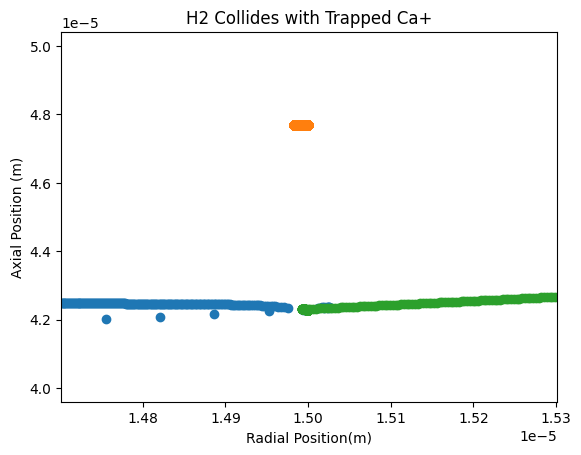

In [48]:
P = 3e-8 # pressure in pascals or multiply by 1e-2mbar/Pa
T = 300 # temperature in kelvin
sigmaV = 100e-6 # fall-off of potential outside trapping region
dv = 20.0 # bin size for particle speed in determining if collision occurs
vmax = 5000 # maximum particle speed we allow
Nrmid = (Nr-1)/2
Nzmid = (Nz-1)/2
#println("ir = ",ir)
first = 10; last=Nt
l = 1
dsepz = 600 # starting separation between ions in virtual units
vbumpr = 0 # starting velocity in r of the lth ion in the chain
vbumpz = 0 # starting velocity in z of the lth ion in the chain
offsetz = 0 # starting distance from eq. in z of the lth ion in the chain
offsetr = 0 # starting distance from eq. in r of the lth ion in the chain
    
# We set all our initial values for the simulation
vf = makeVf(Ni,q,m,l,dsepz,offsetr,offsetz,vbumpr,vbumpz)
z = 4720 ;v = 1000; t =pi/2.0
vz=v*cos(t)/dvr;vr = v*sin(t)/dvz
r = Nrmid/2 #over-rode from 2 to allow collisions to occur faster
Nc = 1
    
println("vr = ",vr)
println("vz = ",vz)


rs,zs,vrs,vzs,rcolls,zcolls,vrcolls,vzcolls = runCollision(vf,r,z,vr,vz,q,mH2,aH2,Nt,dt,RF,DC,Nr,Nz,dr,dz,dvr,dvz,vl,I0,nul,dnul,nu0,A,Ti)    

println((zs[2]-zcolls[1])*dz)
#println(zs[1,1])
#println(zcolls[1,1])

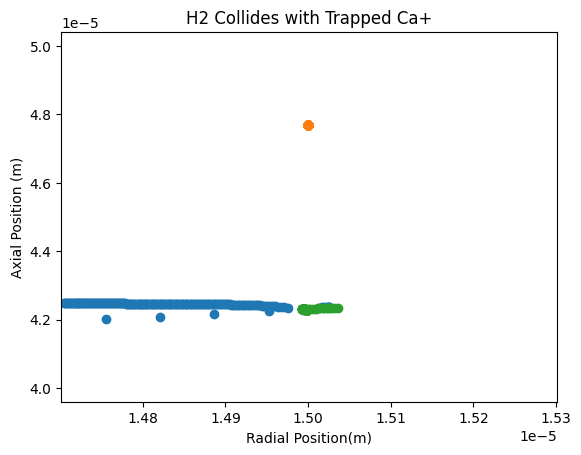

In [69]:
first = 7200;last = Nt-32600
plotPieceWise(Nc,Ni,dr,dz,rcolls,rs,zcolls,zs,first,last,"H2 Collides with Trapped Ca+","Radial Position(m)","Axial Position (m)",49*Dr/100,51*Dr/100,22*Dz/50,28*Dz/50)


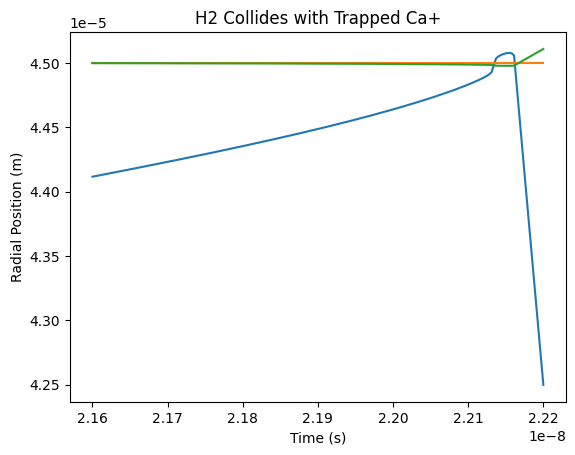

In [70]:
plotThing(Nc,Ni,dt,dz,rcolls,rs,first,last,"H2 Collides with Trapped Ca+","Time (s)","Radial Position (m)")


vr = 0.33333333333333337
vz = 6.123233995736766e-17
Position out of simulation in r 10000.146771404368 Particle # 1 vf = [10000.146771404368, 3999.8111198555553, 0.32890361365066406, -1.856781104974382e-5, 1.6e-19, 3.34e-27, 8.0e-31]
6.299999999904798e-6


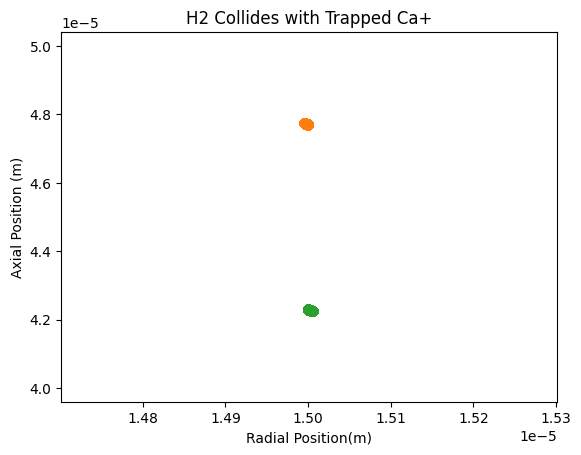

In [40]:
P = 3e-8 # pressure in pascals or multiply by 1e-2mbar/Pa
T = 300 # temperature in kelvin
sigmaV = 100e-6 # fall-off of potential outside trapping region
dv = 20.0 # bin size for particle speed in determining if collision occurs
vmax = 5000 # maximum particle speed we allow
Nrmid = (Nr-1)/2
Nzmid = (Nz-1)/2
#println("ir = ",ir)
first = 10; last=Nt
l = 1
dsepz = 600 # starting separation between ions in virtual units
vbumpr = 0 # starting velocity in r of the lth ion in the chain
vbumpz = 0 # starting velocity in z of the lth ion in the chain
offsetz = 0 # starting distance from eq. in z of the lth ion in the chain
offsetr = 0 # starting distance from eq. in r of the lth ion in the chain
    
# We set all our initial values for the simulation
vf = makeVf(Ni,q,m,l,dsepz,offsetr,offsetz,vbumpr,vbumpz)
z = 4000 ;v = 1000; t =pi/2.0
vz=v*cos(t)/dvr;vr = v*sin(t)/dvz
r = Nrmid/2 #over-rode from 2 to allow collisions to occur faster
Nc = 1
    
println("vr = ",vr)
println("vz = ",vz)


rs,zs,vrs,vzs,rcolls,zcolls,vrcolls,vzcolls = runCollision(vf,r,z,vr,vz,q,mH2,aH2,Nt,dt,RF,DC,Nr,Nz,dr,dz,dvr,dvz,vl,I0,nul,dnul,nu0,A,Ti)    
plotPieceWise(Nc,Ni,dr,dz,rcolls,rs,zcolls,zs,1,Nt,"H2 Collides with Trapped Ca+","Radial Position(m)","Axial Position (m)",49*Dr/100,51*Dr/100,22*Dz/50,28*Dz/50)
println((zs[2]-zcolls[1])*dz)
#println(zs[1,1])
#println(zcolls[1,1])

In [9]:
# Now we push the ions about and track their positions


P = 3e-8 # pressure in pascals or multiply by 1e-2mbar/Pa
T = 300 # temperature in kelvin
sigmaV = 100e-6 # fall-off of potential outside trapping region
dv = 20.0 # bin size for particle speed in determining if collision occurs
vmax = 5000 # maximum particle speed we allow
Nrmid = (Nr-1)/2
Nzmid = (Nz-1)/2

#f = open("test.txt","w")
#write(f,"Start file \n")
#write(f,"rs, zs, vrs, vzs, rcolls, zcolls, vrcolls, vzcolls, pr1, pz1, pr2, pz2, E1, E2")
#rs,zs,vrs,vzs,rcolls,zcolls,vrcolls,vzcolls = runMCCollision(Nc,vf,q,mH2,aH2,Nt,dt,RF,DC,Nr,Nz,dr,dz,dvr,dvz,vl,I0,nul,dnul,nu0,A,Ti,P,T,sigmaV,dv,vmax)
izmax = 1;ivmax = 10;itmax = 1
rs = zeros(Nt)
fileName = "test2.csv"
open(fileName,"w") do file # append to a file
    writedlm(file,["ri, vi, thetai, E1, pr1, pz1, E2, pr2, pz2, Eion1, prion1, pzion1, Eion2, prion2, pzion2, ion, minD, vPerp, cross"],",") # write the output
end
for iz=1:izmax,iv=1:ivmax,it=1:itmax
    #println("ir = ",ir)
    first = 10; last=Nt
    l = 1
    #dsepz = 450 # starting separation between ions in virtual units
    dsepz = 600 # starting separation between ions in virtual units
    vbumpr = 0 # starting velocity in r of the lth ion in the chain
    vbumpz = 0 # starting velocity in z of the lth ion in the chain
    offsetz = 0 # starting distance from eq. in z of the lth ion in the chain
    offsetr = 0 # starting distance from eq. in r of the lth ion in the chain
    
    # We set all our initial values for the simulation
    vf = makeVf(Ni,q,m,l,dsepz,offsetr,offsetz,vbumpr,vbumpz)
    z = 2+ (iz-1)*(Nz-4)/(izmax-1);v = iv*vmax/ivmax; t =(it-1)*(pi)/(itmax-1)
    t = pi/2 # override to shoot head-on
    #z = vf[1,2] + (iz-1)*abs(vf[2,2]-vf[1,2])/(10*(izmax-1))# override to create denser plots
    z = vf[1,2] + 1.5e-7/dz# override to create denser plots
    vz=v*cos(t)/dvr;vr = v*sin(t)/dvz
    r = Nrmid/2 #over-rode from 2 to allow collisions to occur faster
    Nc = 1
    
    println("vr = ",vr)
    println("vz = ",vz)
    # for debugging
    #println("Collisional particle starts with ","r = ",r," z = ",z," vr = ",vr," vz = ",vz)
#     r-=100
    
    rs,zs,vrs,vzs,rcolls,zcolls,vrcolls,vzcolls = runCollision(vf,r,z,vr,vz,q,mH2,aH2,Nt,dt,RF,DC,Nr,Nz,dr,dz,dvr,dvz,vl,I0,nul,dnul,nu0,A,Ti)    
#     plotPieceWise(Nc,Ni,dr,dz,rcolls,rs,zcolls,zs,1,Nt,"H2 Collides with Trapped Ca+","Radial Position(m)","Axial Position (m)",0,Dr,0,Dz)
#     plotThing(Nc,Ni,dt,dz,zcolls,zs,1,Nt,"H2 Collides with Trapped Ca+","Time (s)","Axial Position (m)")
    
    # We find the last time step before the collisional particle leaves the simulation
    for j=1:Nt-1
        if vzcolls[Nt-j] != 0.0 || vrcolls[Nt-j] != 0.0
            last = Nt-j-50
            break
        end
    end
    
        # We find the inital energy and momenta total (need to factor in potential energy on this energy calculation)
        Eion1 = zeros(Ni);Eion2 = zeros(Ni);prion1 = zeros(Ni);prion2 = zeros(Ni);pzion1 = zeros(Ni);pzion2 = zeros(Ni)
        for i=1:Ni # for each ion
            Eion1[i],prion1[i],pzion1[i] = totalEandP(dvr.*vrs[i,first],dvz.*vzs[i,first],m)
        end
        Uion = potE(q,m,rs[:,first],zs[:,first],Vfield,Ni,dr,dz) #add potential energy
        Eion1 .+= Uion
        Eprpz = totalEandP(dvr.*vrs[:,first],dvz.*vzs[:,first],m)
        Eprpz .+= totalEandP(dvr.*vrcolls[:,first],dvz.*vzcolls[:,first],mH2)
        E1 = Eprpz[1]+sum(Uion);pr1 = Eprpz[2];pz1 = Eprpz[3] # for the total initial energy and momentum

        # We find the final energy and momenta total
        for i=1:Ni # for each ion
            Eion2[i],prion2[i],pzion2[i] = totalEandP(dvr.*vrs[i,Nt],dvz.*vzs[i,Nt],m)
        end
    
    if last > 0
        Uion = potE(q,m,rs[:,Nt],zs[:,Nt],Vfield,Ni,dr,dz) #add potential energy to the ion energies
        Eion2 .+= Uion
        Eprpz = totalEandP(dvr.*vrs[:,last],dvz.*vzs[:,last],m)
        Eprpz .+= totalEandP(dvr.*vrcolls[:,last],dvz.*vzcolls[:,last],mH2)
        E2 = Eprpz[1]+sum(Uion);pr2 = Eprpz[2];pz2 = Eprpz[3] # for the total final energy and momentum
        #E2 = Eprpz[1];pr2 = Eprpz[2];pz2 = Eprpz[3] # for the total final energy and momentum
    else
        println("Error: Collisional particle leaves simulation instantly")
        E2 = 0.0; pr2 = 0.0; pz2 = 0.0
    end
    # We find the distance of closest approach
    # We find the perpendicular velocity at the distance of closest approach
    ion,minD,vPerp = getBandV(rs,rcolls,zs,zcolls,vrs,vrcolls,vzs,vzcolls,Ni,dr,dz)
    
    # We find if the z order of the ions changes during the simulation
    cross = ifCross(zs)
    
    # We write out our results. rinitial, vinitial, thetainitial, E1, pr1, pz1, E2, pr2, pz2, bimpact, vperp, dEion, dprion, dpzion, reorder
    open(fileName,"a") do file # append to a file
        writedlm(file,"\n",",") # write the output
        writedlm(file,[z.*dr,v,t,E1, pr1, pz1, E2, pr2, pz2,Eion1,prion1,pzion1,Eion2,prion2,pzion2,ion,minD,vPerp,cross],",") # write the output
    end
end


vr = 0.08333333333333334
vz = 1.5308084989341915e-17
Position out of simulation in r 10000.064396605272 Particle # 1 vf = [10000.064396605272, 6128.247951588737, 0.06505099466431787, -0.0016127778430295803, 1.6e-19, 3.34e-27, 8.0e-31]
minD = 1.2346771479027842e-6
ion = 1
vr = 0.16666666666666669
vz = 3.061616997868383e-17
Position out of simulation in r 10000.102085980248 Particle # 1 vf = [10000.102085980248, 4739.516833513335, 0.11720094541381461, -0.037386666407670965, 1.6e-19, 3.34e-27, 8.0e-31]
minD = 4.808354918515961e-7
ion = 1
vr = 0.25000000000000006
vz = 4.592425496802574e-17
Position out of simulation in r 10032.963511049466 Particle # 1 vf = [10032.963511049466, 6449.520778126645, 91.46568615397669, 4.787407127443743, 1.6e-19, 3.34e-27, 8.0e-31]
Position out of simulation in r -1.2578817816954562 Particle # 1 vf = [-1.2578817816954562, 5921.412997274672, -4.551504958078596, -0.24158757614838772, 1.6e-19, 6.680000000000001e-26, 0.0]
minD = 3.154366024105964e-8
ion = 1
Crossi

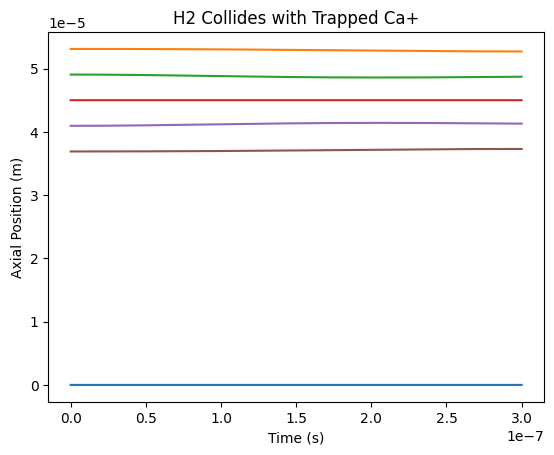

In [113]:
plotThing(Nc,Ni,dt,dz,zcolls,zs,1,Nt,"H2 Collides with Trapped Ca+","Time (s)","Axial Position (m)")

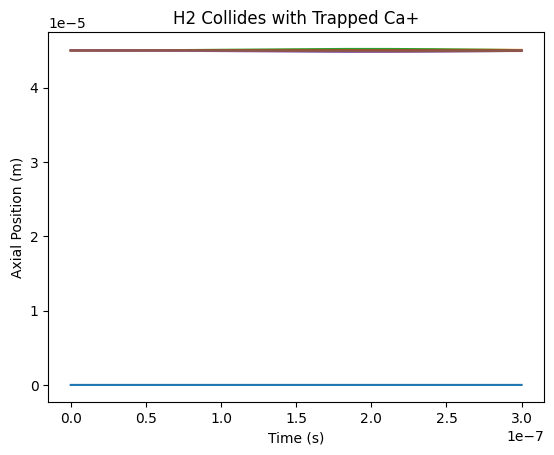

In [114]:
plotThing(Nc,Ni,dt,dz,rcolls,rs,1,Nt,"H2 Collides with Trapped Ca+","Time (s)","Axial Position (m)")

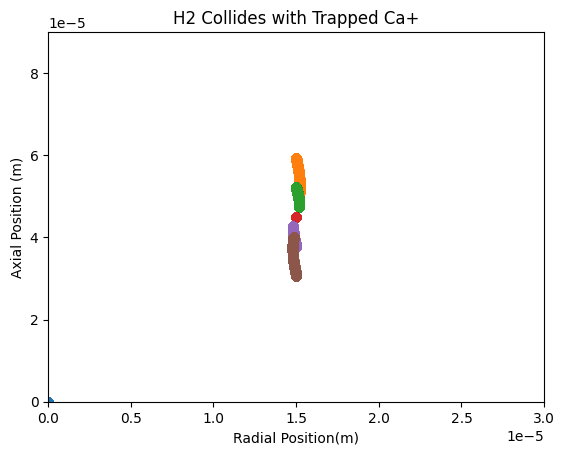

In [103]:
plotPieceWise(Nc,Ni,dr,dz,rcolls,rs,zcolls,zs,1,Nt,"H2 Collides with Trapped Ca+","Radial Position(m)","Axial Position (m)",0,Dr,0,Dz)

In [100]:
subPlotThings(Ni,Nc,dt,dvz,dvz,vzs,vzcolls,first,last,"H2 Collides with Trapped Ca+","Time (s)","Axial Velocity Ion (m/s)","Axial Velocity Coll (m/s)")

# println("Initial velocity Ca+ = ",dvz.*vzs[1,first])
# println("Final velocity Ca+ = ",dvz.*vzs[1,last])
# println("Initial velocity H2 = ",dvz.*vzcolls[1,first])
# println("Final velocity H2 = ",dvz.*vzcolls[1,last])

# #Eprpz = totalEandP(dvr.*vrs[:,first],dvz.*vzs[:,first],m)
# #Eprpz .+= totalEandP(dvr.*vrcolls[:,first],dvz.*vzcolls[:,first],mH2)
# #E1 = Eprpz[1];pr1 = Eprpz[2];pz1 = Eprpz[3]
# #Eprpz = totalEandP(dvr.*vrs[:,last],dvz.*vzs[:,last],m)
# #Eprpz .+= totalEandP(dvr.*vrcolls[:,last],dvz.*vzcolls[:,last],mH2)
# #E2 = Eprpz[1];pr2 = Eprpz[2];pz2 = Eprpz[3]
# #println("pz1 = ",pz1);println("pz2 = ",pz2);println("pr1 = ",pr1);println("pr2 = ",pr2)

# #println("Fractional Energy Gain = ",(E2-E1)/max(E1,E2),"\nRadial momenta Gain (normalized to H2 at 1cell per unit time)= ",(pr2-pr1)/(mH2*dvr),"\nAxial momenta Gain (normalized to H2 at 1cell per unit time)= ",(pz2-pz1)/(mH2*dvz) )


LoadError: BoundsError: attempt to access 1×10000 Matrix{Float64} at index [2, 1:10000]

In [101]:
subPlotThings(Ni,Nc,dt,dvr,dvr,vrs,vrcolls,first,last,"H2 Collides with Trapped Ca+","Time (s)","Radial Velocity Ion (m/s)","Radial Velocity Coll (m/s)")

# println("Initial velocity Ca+ = ",dvr.*vrs[1,first])
# println("Final velocity Ca+ = ",dvr.*vrs[1,last])
# println("Initial velocity H2 = ",dvr.*vrcolls[1,first])
# println("Final velocity H2 = ",dvr.*vrcolls[1,last])

LoadError: BoundsError: attempt to access 1×10000 Matrix{Float64} at index [2, 1:10000]

In [727]:
# this cell was originally at least intended to check that our doppler cooling approached the doppler limit. It would appear so
first = 4600
gamma = 1e6
kB = 1.38e-23
hbar = 1.05e-34 #plancks constant in J*s
println("1cell/1time (m/s) = ",dz/dt)
doppLimit = (hbar*gamma)/(2*m)
println("Doppler Limit (physical units) = ",doppLimit)
println("Doppler Limit (virtual units) = ",doppLimit/(dvz^2))
println("dvz = ",dvz)
println("1 quanta axial = ",hbar*wz)
println("1 quanta axial square speed (physical units) = ",2*hbar*wz/m)
println("1 quanta radial = ",hbar*wr)
println("1 quanta radial square speed (physical units) = ",2*hbar*wr/m)
plot(aveSpeeds[1,first:last])
#plot(aveSpeeds[2,first:last])
plot(np.ones(last-first)*doppLimit/(dvz^2))
title("Average square speed of all ions")
show()

1cell/1time (m/s) = 1000.0
Doppler Limit (physical units) = 0.0007859281437125748
Doppler Limit (virtual units) = 7.859281437125748e-10
dvz = 1000.0
1 quanta axial = 6.5973445725385655e-28
1 quanta axial square speed (physical units) = 0.019752528660295105
1 quanta radial = 6.597344572538566e-27
1 quanta radial square speed (physical units) = 0.19752528660295104


LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/bowers_b1/.julia/packages/PyCall/twYvK/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('negative dimensions are not allowed')
  File "/home/bowers_b1/.local/lib/python3.8/site-packages/numpy/core/numeric.py", line 192, in ones
    a = empty(shape, dtype, order)


In [185]:
hbar = 1.05e-34 #plancks constant in J*s
c = 2.998e8 #speed of light in m/s
hbar*nu0/(c*m)

0.013547687695675652

In [29]:
println("speed to cover whole sim in one time step = ",Dr/dt)

speed to cover whole sim in one time step = 1.0001e6


In [10]:
println(Dr)
println(Dz)

3.0003e-5
9.0009e-5


In [719]:
println(bimpact*dr)
println(speedimpact)

1.8e-7
1500


In [26]:
f = open("output.txt", "w") 
    write(f,"Test test\n")
write(f, "2.0")
close(f)

In [11]:
open("Test/test"*".csv","w") do file
    writedlm(file,[1,2,[[3,4,5],4,5]],",")
end

In [30]:
450*dz

4.05e-6